In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c alpha-dent

100% 4.55G/4.56G [00:51<00:00, 21.7MB/s]
100% 4.56G/4.56G [00:51<00:00, 94.8MB/s]


In [7]:
!unzip alpha-dent.zip -d ./alpha_dent_data

Archive:  alpha-dent.zip
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_000.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_001.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_002.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_003.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_004.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_005.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_006.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_007.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_008.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_009.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_010.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_011.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_012.jpg  
  inflating: ./alpha_dent_data/AlphaDent/images/test/test_013.jpg  
  inflating: ./alpha_de

In [8]:
import os
import sys
import time
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import yaml
import random
from PIL import Image
import warnings
import json
from collections import defaultdict
import torch
from ultralytics import YOLO
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')
os.environ['WANDB_DISABLED'] = 'true'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

In [10]:
class Config:
    BASE_PATH = '/content/alpha_dent_data/AlphaDent'
    TRAIN_IMAGES_PATH = f'{BASE_PATH}/images/train'
    VALID_IMAGES_PATH = f'{BASE_PATH}/images/valid'
    TEST_IMAGES_PATH = f'{BASE_PATH}/images/test'
    TRAIN_LABELS_PATH = f'{BASE_PATH}/labels/train'
    VALID_LABELS_PATH = f'{BASE_PATH}/labels/valid'
    YAML_CONFIG_PATH = f'{BASE_PATH}/yolo_seg_train.yaml'

    OUTPUT_DIR = '/content/'
    WEIGHTS_DIR = f'{OUTPUT_DIR}/weights'

    MODEL_SIZE = 'yolov8x-seg'
    EPOCHS = 20
    IMAGE_SIZE = 520
    BATCH_SIZE = 12 if torch.cuda.is_available() else 6
    PATIENCE = 5

    # Optimization
    LR0 = 0.001
    LRF = 0.01
    MOMENTUM = 0.937
    WEIGHT_DECAY = 0.0005
    WARMUP_EPOCHS = 3.0

    # Data augmentation
    HSV_H = 0.015
    HSV_S = 0.7
    HSV_V = 0.4
    DEGREES = 0.0
    TRANSLATE = 0.1
    SCALE = 0.5
    SHEAR = 0.0
    PERSPECTIVE = 0.0
    FLIPUD = 0.0
    FLIPLR = 0.5
    MOSAIC = 1.0
    MIXUP = 0.0
    COPY_PASTE = 0.0

    # Loss weights
    BOX = 7.5
    CLS = 0.5
    DFL = 1.5

    # Inference
    CONF_THRESHOLD = 0.25
    IOU_THRESHOLD = 0.45
    MAX_DET = 300

    CLASS_INFO = {
        0: {'name': 'Abrasion', 'description': 'Teeth with mechanical wear of hard tissues'},
        1: {'name': 'Filling', 'description': 'Dental fillings of various types'},
        2: {'name': 'Crown', 'description': 'Dental crown (restoration)'},
        3: {'name': 'Caries Class 1', 'description': 'Caries in fissures and pits'},
        4: {'name': 'Caries Class 2', 'description': 'Caries on proximal surfaces of molars/premolars'},
        5: {'name': 'Caries Class 3', 'description': 'Caries on proximal surfaces of incisors/canines without incisal edge'},
        6: {'name': 'Caries Class 4', 'description': 'Caries on proximal surfaces of incisors/canines with incisal edge'},
        7: {'name': 'Caries Class 5', 'description': 'Cervical caries (buccal/lingual surfaces)'},
        8: {'name': 'Caries Class 6', 'description': 'Caries on incisal edges or cusps'}
    }

    NUM_CLASSES = len(CLASS_INFO)

config = Config()

In [11]:
os.makedirs(config.WEIGHTS_DIR, exist_ok=True)

In [12]:
def check_gpu():
    print(f'PyTorch Version: {torch.__version__}')
    print(f'CUDA Available: {torch.cuda.is_available()}')
    if torch.cuda.is_available():
        print(f'CUDA Device: {torch.cuda.get_device_name(0)}')
        print(f'CUDA Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB')
    return torch.cuda.is_available()

In [13]:
def load_existing_yaml_config():
    if os.path.exists(config.YAML_CONFIG_PATH):
        try:
            with open(config.YAML_CONFIG_PATH, 'r') as f:
                existing_config = yaml.safe_load(f)
            print(f"Loaded existing YAML config from: {config.YAML_CONFIG_PATH}")
            return existing_config
        except Exception as e:
            print(f"Error loading existing YAML: {e}")
    return None

In [14]:
def create_yolo_config():
    """Create or update YOLO configuration."""
    existing_config = load_existing_yaml_config()

    yolo_config = {
        'path': config.BASE_PATH,
        'train': 'images/train',
        'val': 'images/valid',
        'test': 'images/test',
        'nc': config.NUM_CLASSES,
        'names': [config.CLASS_INFO[i]['name'] for i in range(config.NUM_CLASSES)]
    }

    if existing_config and 'names' in existing_config:
        if len(existing_config['names']) == config.NUM_CLASSES:
            yolo_config['names'] = existing_config['names']
            print("Using class names from existing YAML config")

    # Save custom config
    custom_yaml_path = f'{config.OUTPUT_DIR}/alphadent_config.yaml'
    with open(custom_yaml_path, 'w') as f:
        yaml.dump(yolo_config, f, default_flow_style=False)

    print(f"Created custom YAML config at: {custom_yaml_path}")
    print(f"Classes: {yolo_config['names']}")
    return custom_yaml_path

In [15]:
def analyze_dataset():
    """Comprehensive dataset analysis."""
    print("=" * 60)
    print("DATASET ANALYSIS")
    print("=" * 60)

    # Count images
    train_images = sorted(glob.glob(f'{config.TRAIN_IMAGES_PATH}/*.jpg'))
    valid_images = sorted(glob.glob(f'{config.VALID_IMAGES_PATH}/*.jpg'))
    test_images = sorted(glob.glob(f'{config.TEST_IMAGES_PATH}/*.jpg'))

    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(valid_images)}")
    print(f"Test images: {len(test_images)}")

    # Analyze class distribution
    def analyze_class_distribution(labels_path, split_name):
        class_counts = defaultdict(int)
        total_annotations = 0
        files_with_annotations = 0

        label_files = glob.glob(f'{labels_path}/*.txt')

        for label_file in tqdm(label_files, desc=f"Analyzing {split_name} labels", leave=False):
            if os.path.exists(label_file) and os.path.getsize(label_file) > 0:
                try:
                    with open(label_file, 'r') as f:
                        lines = f.readlines()
                        file_has_annotations = False
                        for line in lines:
                            if line.strip():
                                parts = line.strip().split()
                                if parts:
                                    class_id = int(parts[0])
                                    if 0 <= class_id < config.NUM_CLASSES:
                                        class_counts[class_id] += 1
                                        total_annotations += 1
                                        file_has_annotations = True
                        if file_has_annotations:
                            files_with_annotations += 1
                except Exception as e:
                    continue

        print(f"\n{split_name.upper()} SET ANALYSIS:")
        print(f"  Files with annotations: {files_with_annotations}/{len(label_files)}")
        print(f"  Total annotations: {total_annotations}")
        print(f"  Class distribution:")
        for class_id in range(config.NUM_CLASSES):
            count = class_counts.get(class_id, 0)
            percentage = (count / total_annotations * 100) if total_annotations > 0 else 0
            class_name = config.CLASS_INFO[class_id]['name']
            print(f"    Class {class_id} ({class_name}): {count} ({percentage:.1f}%)")

        return class_counts, total_annotations

    train_class_counts, train_total = analyze_class_distribution(config.TRAIN_LABELS_PATH, "training")
    valid_class_counts, valid_total = analyze_class_distribution(config.VALID_LABELS_PATH, "validation")

    return {
        'train_images': len(train_images),
        'valid_images': len(valid_images),
        'test_images': len(test_images),
        'train_annotations': train_total,
        'valid_annotations': valid_total,
        'train_class_dist': dict(train_class_counts),
        'valid_class_dist': dict(valid_class_counts)
    }

In [16]:
def visualize_sample_images(num_samples=4):
    train_images = sorted(glob.glob(f'{config.TRAIN_IMAGES_PATH}/*.jpg'))

    if len(train_images) < num_samples:
        num_samples = len(train_images)

    sample_images = random.sample(train_images, num_samples)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, img_path in enumerate(sample_images):
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load corresponding annotation
        img_name = os.path.basename(img_path).replace('.jpg', '')
        label_path = f'{config.TRAIN_LABELS_PATH}/{img_name}.txt'

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            h, w = image.shape[:2]

            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) > 5:  # Segmentation format
                        class_id = int(parts[0])
                        # normalized to pixel
                        coords = list(map(float, parts[1:]))
                        points = []
                        for j in range(0, len(coords), 2):
                            x = int(coords[j] * w)
                            y = int(coords[j + 1] * h)
                            points.append((x, y))

                        if len(points) > 2:
                            # Draw polygon
                            pts = np.array(points, np.int32)
                            pts = pts.reshape((-1, 1, 2))
                            cv2.polylines(image, [pts], True, (0, 255, 0), 2)

                            if points:
                                class_name = config.CLASS_INFO[class_id]['name']
                                cv2.putText(image, f'C{class_id}: {class_name}',
                                          points[0], cv2.FONT_HERSHEY_SIMPLEX,
                                          0.5, (255, 0, 0), 1)

        axes[i].imshow(image)
        axes[i].set_title(f'Sample {i+1}: {img_name}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_DIR}/sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

In [17]:
def create_optimized_model():
    model = YOLO(f'{config.MODEL_SIZE}.pt')

    # Print model info
    print(f"\nModel: {config.MODEL_SIZE}")
    print(f"Parameters: {sum(p.numel() for p in model.model.parameters()):,}")

    return model

In [18]:
def train_model(model, yaml_path):
    print("=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        if gpu_memory > 15 * 1024**3:
            batch_size = 16
        elif gpu_memory > 10 * 1024**3:
            batch_size = 12
        elif gpu_memory > 6 * 1024**3:
            batch_size = 8
        else:
            batch_size = 4
    else:
        batch_size = 2

    print(f"Using batch size: {batch_size}")

    results = model.train(
        data=yaml_path,
        epochs=config.EPOCHS,
        imgsz=config.IMAGE_SIZE,
        batch=batch_size,
        patience=config.PATIENCE,
        save=True,
        save_period=10,
        project=config.OUTPUT_DIR,
        name='alphadent_yolov8x_optimized',
        exist_ok=True,
        pretrained=True,
        optimizer='AdamW',
        lr0=config.LR0,
        lrf=config.LRF,
        momentum=config.MOMENTUM,
        weight_decay=config.WEIGHT_DECAY,
        warmup_epochs=config.WARMUP_EPOCHS,
        warmup_momentum=0.8,
        warmup_bias_lr=0.1,
        box=config.BOX,
        cls=config.CLS,
        dfl=config.DFL,
        hsv_h=config.HSV_H,
        hsv_s=config.HSV_S,
        hsv_v=config.HSV_V,
        degrees=config.DEGREES,
        translate=config.TRANSLATE,
        scale=config.SCALE,
        shear=config.SHEAR,
        perspective=config.PERSPECTIVE,
        flipud=config.FLIPUD,
        fliplr=config.FLIPLR,
        mosaic=config.MOSAIC,
        mixup=config.MIXUP,
        copy_paste=config.COPY_PASTE,
        plots=True,
        device=0 if torch.cuda.is_available() else 'cpu',
        workers=4,
        verbose=True,
        amp=True,
        val=True,
        close_mosaic=10,
        auto_augment='randaugment',
        erasing=0.4,
    )

    return results

In [19]:
def validate_model(model, yaml_path):
    """Validate the trained model."""
    print("=" * 60)
    print("VALIDATING MODEL")
    print("=" * 60)

    try:
        metrics = model.val(
            data=yaml_path,
            imgsz=config.IMAGE_SIZE,
            batch=1,
            conf=0.001,
            iou=0.5,
            max_det=config.MAX_DET,
            device=0 if torch.cuda.is_available() else 'cpu',
            plots=True,
            save_json=True,
        )

        print(f"\nValidation Results:")
        print(f"Box mAP@50: {metrics.box.map50:.4f}")
        print(f"Box mAP@50-95: {metrics.box.map:.4f}")
        print(f"Seg mAP@50: {metrics.seg.map50:.4f}")
        print(f"Seg mAP@50-95: {metrics.seg.map:.4f}")

        # Per-class metrics
        if hasattr(metrics.seg, 'ap_class_index'):
            print("\nPer-class Segmentation mAP@50:")
            for i, class_idx in enumerate(metrics.seg.ap_class_index):
                if i < len(metrics.seg.ap50):
                    class_name = config.CLASS_INFO[class_idx]['name']
                    print(f"  Class {class_idx} ({class_name}): {metrics.seg.ap50[i]:.4f}")

        return metrics
    except Exception as e:
        print(f"Validation error: {e}")
        return None

In [20]:
def convert_to_submission_format(results, image_paths):
    submission_rows = []

    for idx, result in enumerate(results):
        image_id = os.path.basename(image_paths[idx]).replace('.jpg', '')

        if result.masks is not None and len(result.masks) > 0:
            try:
                # Get masks, classes, and confidences
                masks = result.masks.xy
                classes = result.boxes.cls.cpu().numpy().astype(int)
                confidences = result.boxes.conf.cpu().numpy()
                h, w = result.orig_shape

                # Process each detection
                for mask_idx in range(len(masks)):
                    if mask_idx < len(classes) and mask_idx < len(confidences):
                        polygon = masks[mask_idx]

                        if len(polygon) >= 3:  # Valid polygon (at least 3 points)
                            normalized_coords = []
                            for point in polygon:
                                x_norm = float(point[0]) / w
                                y_norm = float(point[1]) / h
                                # Ensure coordinates are within [0, 1]
                                x_norm = max(0.0, min(1.0, x_norm))
                                y_norm = max(0.0, min(1.0, y_norm))
                                normalized_coords.extend([x_norm, y_norm])

                            # Format polygon string with high precision
                            poly_str = ' '.join([f'{coord:.8f}' for coord in normalized_coords])

                            submission_rows.append({
                                'patient_id': image_id,
                                'class_id': int(classes[mask_idx]),
                                'confidence': float(confidences[mask_idx]),
                                'poly': poly_str
                            })
            except Exception as e:
                print(f"Error processing result for image {idx}: {e}")
                continue

    return submission_rows

In [21]:
def run_inference_and_create_submission(model):
    print("=" * 60)
    print("RUNNING INFERENCE")
    print("=" * 60)

    test_images = sorted(glob.glob(f'{config.TEST_IMAGES_PATH}/*.jpg'))
    all_submission_rows = []

    inference_batch_size = 4 if torch.cuda.is_available() else 2

    print(f"Processing {len(test_images)} test images...")

    for i in tqdm(range(0, len(test_images), inference_batch_size), desc="Running inference"):
        batch_images = test_images[i:i + inference_batch_size]

        try:
            # Run inference with multiple confidence thresholds
            results = model.predict(
                batch_images,
                imgsz=config.IMAGE_SIZE,
                conf=config.CONF_THRESHOLD,
                iou=config.IOU_THRESHOLD,
                max_det=config.MAX_DET,
                device=0 if torch.cuda.is_available() else 'cpu',
                verbose=False,
                agnostic_nms=True,
                retina_masks=True,
                augment=True,  # Test Time Augmentation
            )

            # Convert results to submission format
            batch_rows = convert_to_submission_format(results, batch_images)
            all_submission_rows.extend(batch_rows)

        except Exception as e:
            print(f"Error in batch {i//inference_batch_size}: {e}")
            continue

    print(f"Generated {len(all_submission_rows)} predictions")

    # Create submission dataframe
    submission_df = pd.DataFrame(all_submission_rows)

    # Ensure all test images have at least one prediction
    all_test_ids = [os.path.basename(img).replace('.jpg', '') for img in test_images]

    if len(submission_df) > 0:
        predicted_ids = submission_df['patient_id'].unique()
        missing_ids = set(all_test_ids) - set(predicted_ids)
    else:
        missing_ids = set(all_test_ids)

    # add dummy predictions for images without detections
    if missing_ids:
        print(f"Adding dummy predictions for {len(missing_ids)} images without detections")
        dummy_rows = []
        for img_id in missing_ids:
            # small dummy polygon (square in corner)
            dummy_rows.append({
                'patient_id': img_id,
                'class_id': 0,
                'confidence': 0.01,
                'poly': '0.05 0.05 0.05 0.15 0.15 0.15 0.15 0.05'
            })

        dummy_df = pd.DataFrame(dummy_rows)
        submission_df = pd.concat([submission_df, dummy_df], ignore_index=True)

    submission_df = submission_df.sort_values(['patient_id', 'confidence'], ascending=[True, False])

    submission_df = submission_df[['patient_id', 'class_id', 'confidence', 'poly']]

    submission_df.to_csv(f'{config.OUTPUT_DIR}/submission.csv', index=False)

    high_conf_threshold = 0.5
    high_conf_df = submission_df[submission_df['confidence'] >= high_conf_threshold].copy()

    # all test images have at least one prediction
    high_conf_ids = high_conf_df['patient_id'].unique()
    missing_high_conf = set(all_test_ids) - set(high_conf_ids)

    if missing_high_conf:
        for img_id in missing_high_conf:
            img_preds = submission_df[submission_df['patient_id'] == img_id]
            if len(img_preds) > 0:
                # Take the highest confidence prediction for this image
                high_conf_df = pd.concat([high_conf_df, img_preds.head(1)], ignore_index=True)

    high_conf_df = high_conf_df.sort_values(['patient_id', 'confidence'], ascending=[True, False])
    high_conf_df.to_csv(f'{config.OUTPUT_DIR}/submission_high_conf.csv', index=False)

    # Print submission statistics
    print(f"\nSubmission Statistics:")
    print(f"Total predictions: {len(submission_df)}")
    print(f"Unique images: {len(submission_df['patient_id'].unique())}")
    print(f"High confidence predictions: {len(high_conf_df)}")

    print(f"\nPredictions per class:")
    class_dist = submission_df['class_id'].value_counts().sort_index()
    for class_id, count in class_dist.items():
        if 0 <= class_id < config.NUM_CLASSES:
            class_name = config.CLASS_INFO[class_id]['name']
            percentage = (count / len(submission_df) * 100)
            print(f"  Class {class_id} ({class_name}): {count} ({percentage:.1f}%)")

    print(f"\nConfidence distribution:")
    print(f"  Mean: {submission_df['confidence'].mean():.3f}")
    print(f"  Median: {submission_df['confidence'].median():.3f}")
    print(f"  Std: {submission_df['confidence'].std():.3f}")
    print(f"  Min: {submission_df['confidence'].min():.3f}")
    print(f"  Max: {submission_df['confidence'].max():.3f}")

    return submission_df

In [22]:
def main():
    print("=" * 80)
    print("ALPHADENT YOLOV8 OPTIMIZED SEGMENTATION PIPELINE")
    print("=" * 80)

    gpu_available = check_gpu()

    dataset_stats = analyze_dataset()

    print("\nVisualizing sample images...")
    visualize_sample_images()

    yaml_path = create_yolo_config()

    model = create_optimized_model()

    training_results = train_model(model, yaml_path)

    best_model_path = f'{config.OUTPUT_DIR}/alphadent_yolov8x_optimized/weights/best.pt'
    if os.path.exists(best_model_path):
        print(f"Loading best model weights from: {best_model_path}")
        model = YOLO(best_model_path)
    else:
        print("Best model weights not found, using current model")

    validation_metrics = validate_model(model, yaml_path)

    submission_df = run_inference_and_create_submission(model)

    print("=" * 80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print(f"Submission files saved:")
    print(f"  - submission.csv")
    print(f"  - submission_high_conf.csv")
    print(f"  - Model weights: alphadent_yolov8x_optimized/weights/best.pt")

ALPHADENT YOLOV8 OPTIMIZED SEGMENTATION PIPELINE
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device: Tesla T4
CUDA Memory: 14 GB
DATASET ANALYSIS
Training images: 1237
Validation images: 83
Test images: 135


Analyzing training labels:   0%|          | 0/1237 [00:00<?, ?it/s]


TRAINING SET ANALYSIS:
  Files with annotations: 1237/1237
  Total annotations: 12032
  Class distribution:
    Class 0 (Abrasion): 5957 (49.5%)
    Class 1 (Filling): 2187 (18.2%)
    Class 2 (Crown): 570 (4.7%)
    Class 3 (Caries Class 1): 742 (6.2%)
    Class 4 (Caries Class 2): 1026 (8.5%)
    Class 5 (Caries Class 3): 474 (3.9%)
    Class 6 (Caries Class 4): 43 (0.4%)
    Class 7 (Caries Class 5): 981 (8.2%)
    Class 8 (Caries Class 6): 52 (0.4%)


Analyzing validation labels:   0%|          | 0/83 [00:00<?, ?it/s]


VALIDATION SET ANALYSIS:
  Files with annotations: 83/83
  Total annotations: 872
  Class distribution:
    Class 0 (Abrasion): 409 (46.9%)
    Class 1 (Filling): 186 (21.3%)
    Class 2 (Crown): 19 (2.2%)
    Class 3 (Caries Class 1): 62 (7.1%)
    Class 4 (Caries Class 2): 73 (8.4%)
    Class 5 (Caries Class 3): 33 (3.8%)
    Class 6 (Caries Class 4): 4 (0.5%)
    Class 7 (Caries Class 5): 81 (9.3%)
    Class 8 (Caries Class 6): 5 (0.6%)

Visualizing sample images...


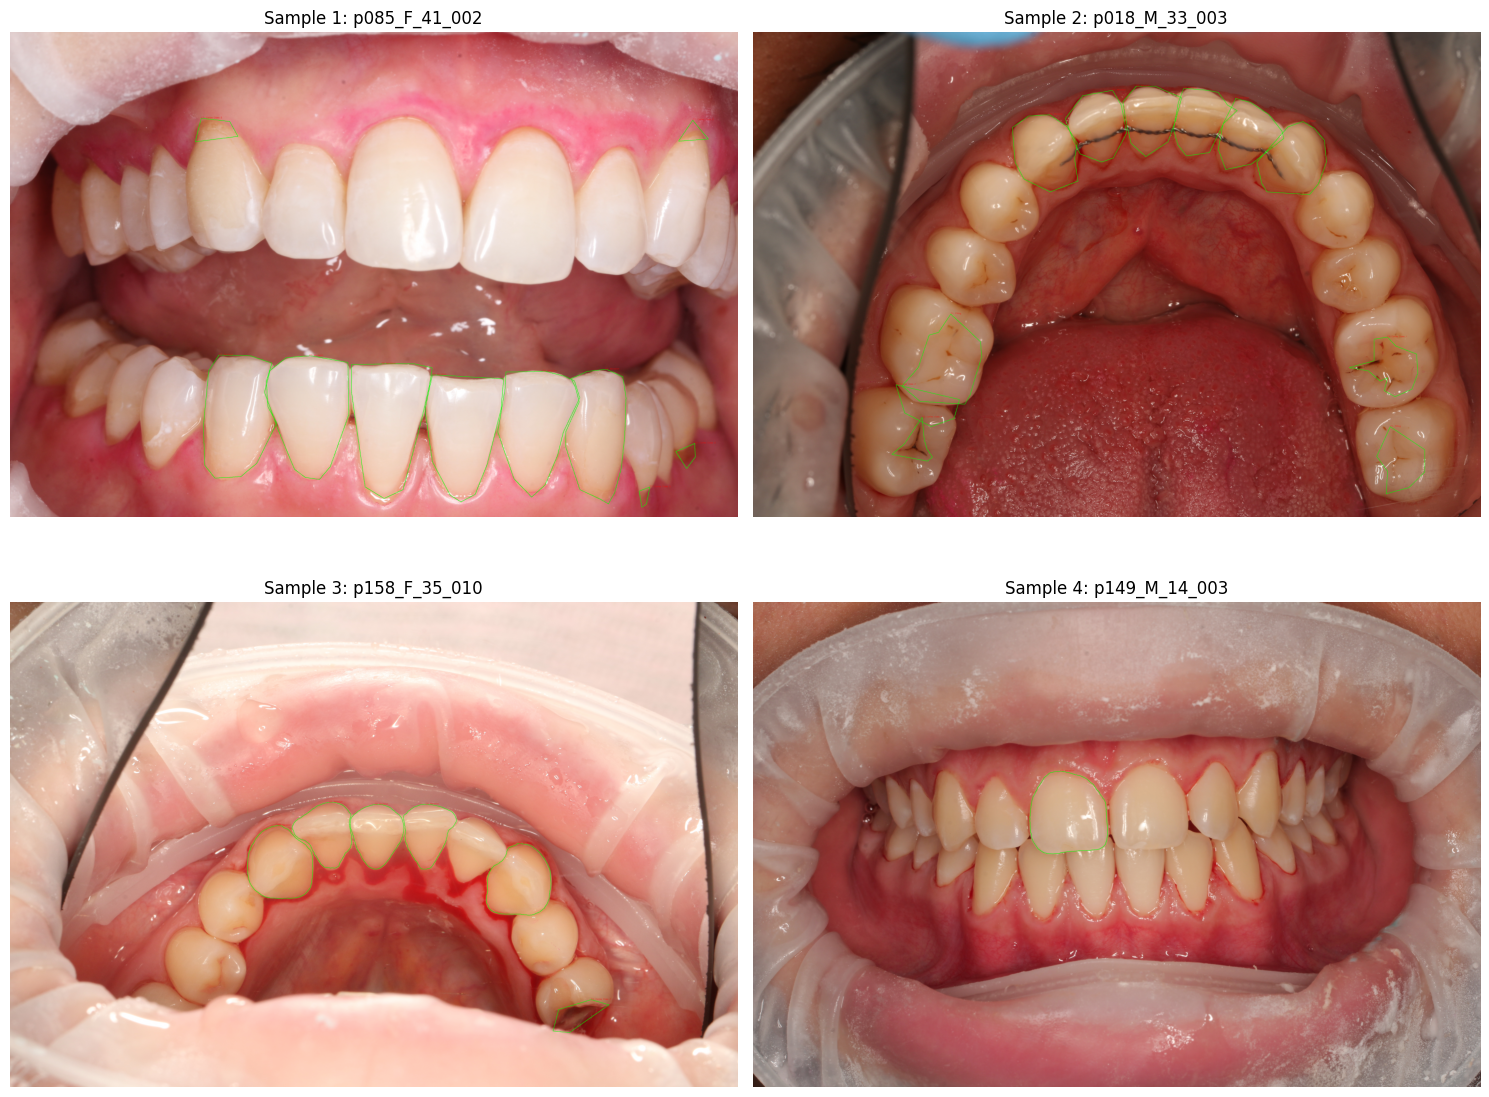

Loaded existing YAML config from: /content/alpha_dent_data/AlphaDent/yolo_seg_train.yaml
Using class names from existing YAML config
Created custom YAML config at: /content//alphadent_config.yaml
Classes: {0: 'Abrasion', 1: 'Filling', 2: 'Crown', 3: 'Caries 1 class', 4: 'Caries 2 class', 5: 'Caries 3 class', 6: 'Caries 4 class', 7: 'Caries 5 class', 8: 'Caries 6 class'}



Model: yolov8x-seg
Parameters: 71,827,888
STARTING TRAINING
Using batch size: 12
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content//alphadent_config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=520, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=alphadent_yolov8x_optimized, nbs=64, nms=False, opset=None, optimiz

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

AMP: checks passed ✅
WARNING ⚠️ imgsz=[520] must be multiple of max stride 32, updating to [544]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1197.5±1358.9 MB/s, size: 3287.1 KB)


train: Scanning /content/alpha_dent_data/AlphaDent/labels/train... 1237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1237/1237 [00:06<00:00, 203.33it/s]


train: New cache created: /content/alpha_dent_data/AlphaDent/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1165.1±1419.4 MB/s, size: 3172.8 KB)


val: Scanning /content/alpha_dent_data/AlphaDent/labels/valid... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:01<00:00, 59.53it/s]

val: New cache created: /content/alpha_dent_data/AlphaDent/labels/valid.cache


Plotting labels to /content/alphadent_yolov8x_optimized/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.00046875), 116 bias(decay=0.0)
Image sizes 544 train, 544 val
Using 2 dataloader workers
Logging results to /content/alphadent_yolov8x_optimized
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.42G      0.938      2.507      1.765      1.037          4        544: 100%|██████████| 104/104 [03:31<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


                   all         83        872      0.374      0.157       0.15     0.0907      0.349       0.13      0.107     0.0531

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.63G     0.9239       2.24      1.314      1.006          7        544: 100%|██████████| 104/104 [02:57<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]

                   all         83        872      0.357      0.276      0.208      0.119      0.338      0.248       0.18     0.0916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.69G     0.9319       2.24      1.256      1.011         31        544: 100%|██████████| 104/104 [02:55<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all         83        872      0.478      0.267      0.218      0.124      0.445      0.238      0.192     0.0991



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.96G     0.9178      2.127      1.228      1.005         13        544: 100%|██████████| 104/104 [02:55<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


                   all         83        872      0.485      0.252      0.225      0.127      0.459       0.24      0.207      0.104

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.94G     0.9278      2.165      1.213      1.004         51        544: 100%|██████████| 104/104 [02:56<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


                   all         83        872      0.595      0.345      0.263      0.153      0.549      0.336      0.239      0.125

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.99G     0.9085      2.093      1.182      0.986          7        544: 100%|██████████| 104/104 [02:53<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


                   all         83        872      0.478      0.301      0.288      0.172      0.462      0.302      0.265      0.146

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.98G     0.8796      2.021      1.141     0.9805         60        544: 100%|██████████| 104/104 [02:51<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         83        872      0.467      0.321      0.263      0.156       0.45      0.316      0.244      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.95G     0.8725      2.004      1.123     0.9759         33        544: 100%|██████████| 104/104 [02:52<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all         83        872      0.508      0.339      0.287      0.176      0.506      0.316      0.273       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.64G     0.8542       1.93      1.044     0.9708         37        544: 100%|██████████| 104/104 [02:48<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         83        872        0.4      0.337      0.311      0.185      0.416      0.299      0.287      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.03G     0.8393      1.891      1.012     0.9558         27        544: 100%|██████████| 104/104 [02:51<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all         83        872      0.537      0.336      0.329      0.203      0.544      0.328      0.322      0.176


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.89G     0.8373      1.928      1.064     0.9869          5        544: 100%|██████████| 104/104 [03:17<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all         83        872      0.566      0.335      0.327      0.194      0.569       0.33      0.315      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20       8.8G     0.8312      1.893      1.034     0.9828          6        544: 100%|██████████| 104/104 [03:11<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all         83        872      0.594      0.366      0.357      0.219      0.583      0.353      0.339      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.84G     0.8184      1.824     0.9893     0.9725         13        544: 100%|██████████| 104/104 [03:10<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all         83        872      0.557       0.38      0.376      0.228      0.542      0.372      0.358        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.54G     0.8072      1.782     0.9694     0.9644         10        544: 100%|██████████| 104/104 [03:12<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


                   all         83        872      0.411      0.366      0.352      0.222      0.457      0.379      0.345      0.188

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.89G     0.7897      1.747     0.9318     0.9605          8        544: 100%|██████████| 104/104 [03:15<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all         83        872      0.562      0.383      0.375      0.229      0.546      0.357      0.354      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.83G     0.7753      1.716     0.9038     0.9515         18        544: 100%|██████████| 104/104 [03:11<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all         83        872      0.459      0.393      0.381      0.239      0.463      0.382       0.37      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.88G     0.7777      1.679     0.8773      0.953         14        544: 100%|██████████| 104/104 [03:09<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


                   all         83        872      0.503      0.388      0.389      0.238      0.512      0.351       0.37      0.212

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.88G     0.7664      1.636     0.8598     0.9372         11        544: 100%|██████████| 104/104 [03:09<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all         83        872      0.484      0.377      0.378      0.235      0.486      0.374      0.375      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20       8.6G     0.7494      1.613      0.844     0.9379          9        544: 100%|██████████| 104/104 [03:02<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         83        872      0.472      0.417      0.406      0.246      0.487      0.383      0.394      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.88G     0.7337      1.571     0.8125      0.932          3        544: 100%|██████████| 104/104 [03:10<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all         83        872      0.502      0.397      0.416      0.256      0.627      0.375      0.392      0.226



20 epochs completed in 1.105 hours.
Optimizer stripped from /content/alphadent_yolov8x_optimized/weights/last.pt, 143.9MB
Optimizer stripped from /content/alphadent_yolov8x_optimized/weights/best.pt, 143.9MB

Validating /content/alphadent_yolov8x_optimized/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8x-seg summary (fused): 125 layers, 71,729,323 parameters, 0 gradients, 343.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:02,  1.20it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 2/4 [00:02<00:02,  1.33s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


                   all         83        872      0.502      0.397      0.415      0.255      0.626      0.376      0.391      0.226
              Abrasion         73        409      0.632      0.907      0.849      0.768       0.64      0.897      0.847      0.679
               Filling         48        186      0.688      0.763      0.737      0.413      0.689      0.726      0.704      0.366
                 Crown          9         19      0.478      0.789      0.744      0.583      0.499      0.787      0.744      0.571
        Caries 1 class         30         62      0.605      0.355      0.429      0.188      0.595      0.306       0.38       0.11
        Caries 2 class         41         73      0.375      0.329      0.312     0.0999       0.32      0.247       0.23     0.0609
        Caries 3 class         23         33      0.103     0.0606     0.0807     0.0212      0.161     0.0606     0.0633     0.0364
        Caries 4 class          3          4          1          0   

val: Scanning /content/alpha_dent_data/AlphaDent/labels/valid.cache... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/83 [00:00<?, ?it/s]

requirements: Ultralytics requirement ['faster-coco-eval>=1.6.7'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.4s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|          | 1/83 [01:03<1:26:22, 63.21s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 2/83 [02:47<1:58:16, 87.61s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 6/83 [07:08<1:41:20, 78.97s/it]

In [ ]:
if __name__ == "__main__":
    main()